## Knowledge Graph
#### Drug-Food or Drug-Supplements interaction prediction

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pykeen.predict import predict_target
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory, CoreTriplesFactory
from pykeen.models import TransE
from pykeen.evaluation import RankBasedEvaluator, OGBEvaluator

from os import listdir

from kg_model import KG_model

### Split data into train, validation and test sets

In [3]:
data_dir = '../data/triplets/'

In [4]:
ddi_df = pd.read_csv(data_dir + 'ddi.tsv', sep='\t', index_col=[0])
ddi_df.head()

,drug1,interaction,drug2
0,DB06605,increase_anticoagulant_activities,DB00001
1,DB06695,increase_anticoagulant_activities,DB00001
2,DB01254,increase_bleeding,DB00001
3,DB01254,increase_hemorrhage,DB00001
4,DB01609,increase_gastrointestinal_bleeding,DB00001


In [ ]:
print('total interactions:', ddi_df.shape[0])
print('unique interactions:', len(set(ddi_df.interaction)))

interaction_counts = ddi_df.groupby(by=['interaction']).size()
interaction_counts

In [ ]:
set(ddi_df.interaction)

In [ ]:
drug_supplement_df = pd.read_csv(data_dir + 'ds_relations.tsv', sep='\t', index_col=[0])
# drug_supplement_df = drug_supplement_df[drug_supplement_df['REL'] != 'has_ingredient']
drug_supplement_df.head()

In [ ]:
print('total interactions:', drug_supplement_df.shape[0])
print('unique interactions:', len(set(drug_supplement_df.REL)))

ds_interaction_counts = drug_supplement_df.groupby(by=['REL']).size()
ds_interaction_counts

In [ ]:
interactions_count = pd.concat([interaction_counts, ds_interaction_counts])
interactions_count.to_csv('interaction_counts.csv', header=['interaction_count'])

In [ ]:
def compute_size(n):
    if n == 2:
        return 1, 1
    if n == 3:
        return 1, 2
    if n == 4:
        return 2, 3
    if n == 5:
        return 3, 4
    if n == 6:
        return 4, 5
    # n == 7
    return 4, 6 

In [ ]:
# train : valid : test = 80 : 10 : 10
def split_data_relation(df_relation):
    
    # too few triplets with the realtion
    if df_relation.shape[0] <= 7:
        train_size, valid_size = compute_size(df_relation.shape[0])
        
        # shuffle df_relation
        df_relation = df_relation.sample(frac=1, random_state=42)
        
        X_train = df_relation.iloc[:train_size]
        X_valid = df_relation.iloc[train_size:valid_size]
        X_test = df_relation.iloc[valid_size:]

    else:
        X_train, X_rem = train_test_split(df_relation, train_size=0.8, random_state=42)
        X_valid, X_test = train_test_split(X_rem, test_size=0.5, random_state=42)
        
    return X_train, X_valid, X_test

In [ ]:
# split drug-supplements relation dataset
def split_drug_supplements_dataset(drug_supplement_df):
    relations = set(drug_supplement_df.REL)
    
    train_triplets = pd.DataFrame(columns=['CUI1', 'REL', 'CUI2'])
    valid_triplets = pd.DataFrame(columns=['CUI1', 'REL', 'CUI2'])
    test_triplets = pd.DataFrame(columns=['CUI1', 'REL', 'CUI2'])

    for rel in relations:
        train, valid, test = split_data_relation(drug_supplement_df[drug_supplement_df['REL'] == rel])
        train_triplets = pd.concat([train_triplets, train])
        valid_triplets = pd.concat([valid_triplets, valid])
        test_triplets = pd.concat([test_triplets, test])

    train_triplets.rename(columns={'CUI1': 'head', 'REL': 'relation', 'CUI2': 'tail'}, inplace=True)
    valid_triplets.rename(columns={'CUI1': 'head', 'REL': 'relation', 'CUI2': 'tail'}, inplace=True)
    test_triplets.rename(columns={'CUI1': 'head', 'REL': 'relation', 'CUI2': 'tail'}, inplace=True)    


    print('train dataset size:', train_triplets.shape[0])
    print('validation dataset size:',valid_triplets.shape[0])
    print('test dataset size:',test_triplets.shape[0])
    
    return train_triplets, valid_triplets, test_triplets

In [ ]:
# split drug-drug interaction dataset (from DrugBank)
def split_ddi_dataset(ddi_df):
    interactions = set(ddi_df.interaction)
    
    train_triplets = pd.DataFrame(columns=['drug1', 'interaction', 'drug2'])
    valid_triplets = pd.DataFrame(columns=['drug1', 'interaction', 'drug2'])
    test_triplets = pd.DataFrame(columns=['drug1', 'interaction', 'drug2'])
    
    for inter in interactions:
        train, valid, test = split_data_relation(ddi_df[ddi_df['interaction'] == inter])
        train_triplets = pd.concat([train_triplets, train])
        valid_triplets = pd.concat([valid_triplets, valid])
        test_triplets = pd.concat([test_triplets, test])
        
    train_triplets.rename(columns={'drug1': 'head', 'interaction': 'relation', 'drug2': 'tail'}, inplace=True)
    valid_triplets.rename(columns={'drug1': 'head', 'interaction': 'relation', 'drug2': 'tail'}, inplace=True)
    test_triplets.rename(columns={'drug1': 'head', 'interaction': 'relation', 'drug2': 'tail'}, inplace=True)    


    print('train dataset size:', train_triplets.shape[0])
    print('validation dataset size:',valid_triplets.shape[0])
    print('test dataset size:',test_triplets.shape[0])
    
    return train_triplets, valid_triplets, test_triplets    
    

In [ ]:
# DrugBank drug-drug interactions
print('DrugBank drug-drug interactions')
train_triplets_ddi, valid_triplets_ddi, test_triplets_ddi = split_ddi_dataset(ddi_df)

print()

# Drug Supplement database - drug-suplement interactions
print('Drug Supplement database - drug-suplement interactions')
train_triplets_ds, valid_triplets_ds, test_triplets_ds = split_drug_supplements_dataset(drug_supplement_df)

In [ ]:
# all interactions
train_triplets = pd.concat([train_triplets_ddi, train_triplets_ds])
valid_triplets = pd.concat([valid_triplets_ddi, valid_triplets_ds])
test_triplets = pd.concat([test_triplets_ddi, test_triplets_ds])

print('All interactions:')
print('train dataset size:', train_triplets.shape[0])
print('validation dataset size:',valid_triplets.shape[0])
print('test dataset size:',test_triplets.shape[0])

In [ ]:
all_relations = set(train_triplets.relation)
print('Number of unique interactions:', len(all_relations))
print(list(all_relations)[:10])

#### Add rest of the data into the training set

In [ ]:
files = listdir(data_dir)

for file in files:
    if file == 'ddi.tsv' or file == '.ipynb_checkpoints' or file == 'ds_relations.tsv':
        continue
    if 'train' in file or 'valid' in file or 'test' in file:
        continue
           
    df = pd.read_csv(data_dir + file, sep='\t', index_col=[0])
    
    # if file == 'ds_relations.tsv':
    #     df = df[df['REL'] == 'has_ingredient']
    
    df.set_axis(['head', 'relation', 'tail'], axis=1, inplace=True) 
    train_triplets = pd.concat([train_triplets, df])
    
print('Final size of train dataset (with other relations):', train_triplets.shape[0]) 

In [ ]:
train_triplets = train_triplets.astype(str)
valid_triplets = valid_triplets.astype(str)
test_triplets = test_triplets.astype(str)

In [ ]:
# save train, valid and test datasets

train_triplets.to_csv(data_dir + 'train.tsv', sep='\t')
valid_triplets.to_csv(data_dir + 'valid.tsv', sep='\t')
test_triplets.to_csv(data_dir + 'test.tsv', sep='\t')

In [5]:
# read data

specification = '_drugbank'

train_triplets = pd.read_csv(data_dir + 'train' + specification + '.tsv', sep='\t')
valid_triplets = pd.read_csv(data_dir + 'valid' + specification + '.tsv', sep='\t')
test_triplets = pd.read_csv(data_dir + 'test' + specification + '.tsv', sep='\t')

In [6]:
train_triplets

,head,relation,tail
0,DB01424,interacts,DB00384
1,DB00292,interacts,DB00282
2,DB01428,interacts,DB00872
3,DB12474,interacts,DB00054
4,DB11641,interacts,DB01016
...,...,...,...
675581,SMP0062895,involved_in_pathway,P35367
675582,SMP0062895,involved_in_pathway,P50148
675583,SMP0062895,involved_in_pathway,Q14643
675584,SMP0062895,involved_in_pathway,P05771


In [7]:
common_drugs = pd.read_csv('../data/common_drugs.csv', sep=';')
common_drugs = common_drugs['DrugBank_id'].values

In [8]:
train_triplets[train_triplets['head'] == common_drugs[3]]

,head,relation,tail
8037,DB00343,interacts,DB00026
10406,DB00343,interacts,DB00284
20712,DB00343,interacts,DB00186
21883,DB00343,interacts,DB00202
35319,DB00343,interacts,DB00289
...,...,...,...
555047,DB00343,in_category,Vasodilating Agents
555048,DB00343,in_category,Vasoprotectives
644024,DB00343,contains,DBSALT000865
644025,DB00343,contains,DBSALT001394


#### Convert datasets into Triples Factory format

In [9]:
def convert_to_triples_factory(data):
    tf_data = TriplesFactory.from_labeled_triples(
      data[["head", "relation", "tail"]].values,
      create_inverse_triples=False,
      entity_to_id=None,
      relation_to_id=None,
      compact_id=False 
    )
    print(tf_data)  
    return tf_data


In [10]:
tf_train = convert_to_triples_factory(train_triplets.astype(str))
tf_valid = convert_to_triples_factory(valid_triplets.astype(str))
tf_test = convert_to_triples_factory(test_triplets.astype(str))



TriplesFactory(num_entities=19917, num_relations=7, create_inverse_triples=False, num_triples=673847)
TriplesFactory(num_entities=2410, num_relations=1, create_inverse_triples=False, num_triples=68534)
TriplesFactory(num_entities=2409, num_relations=1, create_inverse_triples=False, num_triples=68536)


In [11]:
# take just subset of data for testing

train_sub, _ = tf_train.split(0.15)
valid_sub, _ = tf_valid.split(0.15)
test_sub, _ = tf_test.split(0.15)

using automatically assigned random_state=524780834
using automatically assigned random_state=3320739116
using automatically assigned random_state=2025792726


### Model

In [14]:
params = {'epochs': 2, 
          'optimizer': 'adam', 
          'learning_rate': 0.005,
          'loss': 'MarginRankingLoss',
          'batch': 512,
          'embedding_dim': 300,
          'margin': 0.64,
          'evaluator': 'rankedbased',
          'data_name': 'drugbank'
         }
params['epochs']

2

In [ ]:
model_kg = KG_model('complex', tf_train, tf_valid, tf_test, 'jupyter_test')
model_kg.set_params2(params)

print('Training...')
model_kg.train()
print('Training done')

In [13]:
# model_kg.trained_model.metric_results.to_df()

head = common_drugs[0]
relation = 'interacts'

pred = predict_target(
            model = model_kg.trained_model.model, 
            head = head, 
            relation = relation, 
            triples_factory = model_kg.trained_model.training,
        )
pred

TargetPredictions(df=       tail_id     score       tail_label
3773      3773  4.956060          DB08918
2789      2789  4.889006          DB00871
4389      4389  4.857689          DB11827
2609      2609  4.852685          DB00681
2849      2849  4.843045          DB00934
...        ...       ...              ...
28589    28589 -5.563348  sideeffect_5358
10956    10956 -5.580075      disease_880
29970    29970 -5.617806   sideeffect_680
24460    24460 -5.680283  sideeffect_1186
25881    25881 -5.863306  sideeffect_2614

[33046 rows x 3 columns], factory=TriplesFactory(num_entities=33046, num_relations=55, create_inverse_triples=False, num_triples=2070392), target='tail', other_columns_fixed_ids=(3272, 45))

In [18]:
model_kg.trained_model.get_metric('mrr')

0.00031339778797701

In [28]:
metrices = dict()
metrices['hits@10'] = [model_kg.trained_model.get_metric('hits@10')]
metrices['mrr'] = [model_kg.trained_model.get_metric('mrr')]

df_result = pd.DataFrame(metrices)


,hits@10,mrr
0,0.000322,0.000313


In [25]:
from pykeen.trackers import JSONResultTracker
result_tracker = JSONResultTracker('result_tracker.json')

INFO:pykeen.trackers.file:Logging to file:///work/models/result_tracker.json.


In [34]:
result = pipeline(
    training=train_sub,
    testing=test_sub,
    validation=valid_sub,
    model='TransE',
    epochs=10,
)

# result = pipeline(
#     training=train_sub,
#     testing=test_sub,
#     validation=valid_sub,
#     model='ConvKB',
#     epochs=1
# )
# super pomala evaluace

# result = pipeline(
#     training=train_sub,
#     testing=test_sub,
#     validation=valid_sub,
#     model='ConvE',
#     epochs=5
# )

INFO:pykeen.trackers.file:Logging to file:///work/models/test-tracker.csv.csv.


TypeError: 'metrics' is an invalid keyword argument for this function

<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

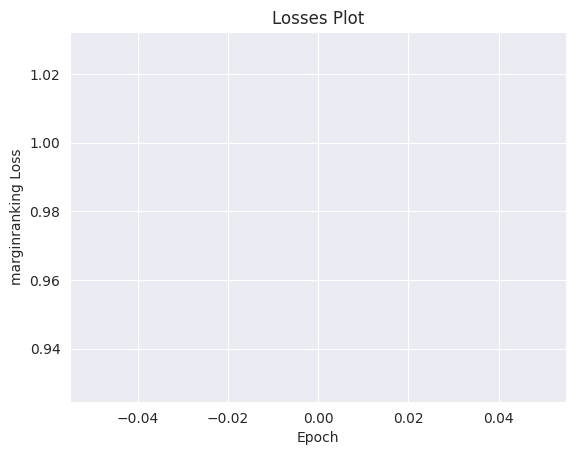

In [19]:
result.plot_losses()

In [20]:
hits_at_10 = result.get_metric('hits@10')
hits_at_10

0.00030339805825242716

In [ ]:
result.metric_results.to_df()

In [30]:
pred = predict_target(
                model = result.model,
                head = common_drugs[3], 
                relation = 'interacts', 
                triples_factory = result.training,
            )

pred_filtered = pred.filter_triples(train_sub)
pred = pred_filtered.add_membership_columns(validation=valid_sub, testing=test_sub)

predicted_tails_df = pred.df.head(100)
predicted_tails_df

,tail_id,score,tail_label,in_validation,in_testing
2237,2237,1.006317,DB00292,False,False
3070,3070,0.991285,DB01167,False,False
3899,3899,0.981812,DB09123,False,False
2571,2571,0.977407,DB00642,False,False
2151,2151,0.951434,DB00203,False,False
...,...,...,...,...,...
3955,3955,0.777734,DB09255,False,False
2675,2675,0.775928,DB00749,False,False
2956,2956,0.773715,DB01046,False,False
4510,4510,0.773324,DB12825,False,False


In [ ]:
result.save_to_directory("results")

---------------------------------------------------------------------------------------

## KG parameters setting

In [ ]:
from pykeen.datasets import Hetionet, BioKG
dataset = Hetionet()
dataset

In [ ]:
labels = dataset.training.entity_id_to_label.values()
for l in labels:
    if 'Compound' in l:
        print(l)

In [ ]:
result = pipeline(
#     dataset=BioKG,
    training=tf_train,
    vlidation=tf_valid,
    model='ComplEx',
    epochs=5,
    evaluator=OGBEvaluator(tf_test),
    model_kwargs={
        'embedding_dim': 1000
    },
    optimizer='Adam',
    optimizer_kwargs = dict(
                lr = 0.001
    ),
    loss = 'MarginRankingLoss',
    device='gpu'
)

In [ ]:
tf_test

In [ ]:
model = result.model
model

In [ ]:
result.plot_losses()
plt.show()

In [ ]:
result.metric_results.to_df()

In [ ]:
result.get_metric('mrr')

In [ ]:
from pykeen.hpo import hpo_pipeline_from_config

In [ ]:
config = {
    'optuna': dict(
        n_trials=5,
    ),
    'pipeline': dict(
        training = tf_train,
        validation = tf_valid,
        testing = tf_test,
        model='TransR',
        model_kwargs_ranges=dict(
               embedding_dim=dict(type=int, low=20, high=160, q=20),
        ),
        optimizer='Adam',
        optimizer_kwargs=dict(lr=0.01),
        loss='marginranking',
        loss_kwargs=dict(margin=1),
        training_loop='slcwa',
        training_kwargs=dict(num_epochs=100, batch_size=128),
        negative_sampler='basic',
        negative_sampler_kwargs=dict(num_negs_per_pos=1),
        evaluator_kwargs=dict(filtered=True),
        evaluation_kwargs=dict(batch_size=128),
        stopper='early',
        stopper_kwargs=dict(frequency=5, patience=2, relative_delta=0.002),
    )
}

In [ ]:
hpo_pipeline_result = hpo_pipeline_from_config(config)

In [ ]:
hpo_pipeline_result.save_to_directory('hpo_results')

In [ ]:
from pykeen.pipeline import pipeline_from_config

In [ ]:
config2 = {
    "metadata": {
    "title": "nations - try",
    "comments": "comment"
  },
  "pipeline": {
    "dataset": "nations",
    "model": "TransE",
    "model_kwargs": {
      "embedding_dim": 50,
      "scoring_fct_norm": 1
    },
    "optimizer": "SGD",
    "optimizer_kwargs": {
      "lr": 0.01
    },
    "loss": "MarginRankingLoss",
    "loss_kwargs": {
      "reduction": "mean",
      "margin": 1
    },
    "training_loop": "slcwa",
    "negative_sampler": "basic",
    "negative_sampler_kwargs": {
      "num_negs_per_pos": 1
    },
    "training_kwargs": {
      "num_epochs": 100,
      "batch_size": 32
    },
    "evaluator_kwargs": {
      "filtered": True
    }
  }
}

pipeline_result = pipeline_from_config(config2)

In [ ]:
pipeline_result.metric_results.to_df()

## Result tracking

In [1]:
import wandb
import os

os.environ["WANDB_API_KEY"] = "a0dcca4cf18920b5c23ec09023f46ffa76caad5b"
wandb.login()

wandb: Currently logged in as: 487616. Use `wandb login --relogin` to force relogin


True

In [2]:
from pykeen.pipeline import pipeline

pipeline_result = pipeline(
    model='RotatE',
    dataset='Kinships',
    result_tracker='wandb',
    result_tracker_kwargs=dict(
        project='pykeen_project',
    ),
)


No random seed is specified. Setting to 1624369303.


Training epochs on cuda:0:   0%|          | 0/5 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/34 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/34 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/34 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/34 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/34 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=2048.


Evaluating on cuda:0:   0%|          | 0.00/1.07k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds


loss,█▇▅▃▁
testing.both.optimistic.adjusted_arithmetic_mean_rank,▁
testing.both.optimistic.adjusted_arithmetic_mean_rank_index,▁
testing.both.optimistic.adjusted_geometric_mean_rank_index,▁
testing.both.optimistic.adjusted_hits_at_k,▁
testing.both.optimistic.adjusted_inverse_harmonic_mean_rank,▁
testing.both.optimistic.arithmetic_mean_rank,▁
testing.both.optimistic.count,▁
testing.both.optimistic.geometric_mean_rank,▁
testing.both.optimistic.harmonic_mean_rank,▁
testing.both.optimistic.hits_at_1,▁


## Beyond the pipeline

In [25]:
from pykeen.models import TransE
from torch.optim import Adam
from pykeen.training import SLCWATrainingLoop

model_name_dict = {'transe': TransE}

model = model_name_dict['transe'](triples_factory=train_sub)
optimizer = Adam(params=model.get_grad_params())

training_loop = SLCWATrainingLoop(
    model=model,
    triples_factory=train_sub,
    optimizer=optimizer,
 
)

_ = training_loop.train(
    triples_factory=train_sub,
    num_epochs=5,
    batch_size=256,
)

No random seed is specified. This may lead to non-reproducible results.


Training epochs on cpu:   0%|          | 0/5 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/1214 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1214 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1214 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1214 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/1214 [00:00<?, ?batch/s]

In [26]:
training_loop.device.type

'cpu'

In [27]:
from pykeen.evaluation import RankBasedEvaluator
evaluator = RankBasedEvaluator()

# Get triples to test
mapped_triples = test_sub.mapped_triples

# Evaluate
results = evaluator.evaluate(
    model=model,
    mapped_triples=mapped_triples,
    batch_size=1024,
    additional_filter_triples=[
        train_sub.mapped_triples,
        valid_sub.mapped_triples,
    ],
)

print(results)

Evaluating on cpu:   0%|          | 0.00/24.7k [00:00<?, ?triple/s]

KeyboardInterrupt: 

In [23]:
from pykeen.models import TransE
from pykeen.training import SLCWATrainingLoop
from pykeen.triples import TriplesFactory
from torch.optim import Adam
from pykeen.datasets import Nations

def train2():
        resolve_device("gpu")
        triples_factory = train_sub
        model = TransE(
            triples_factory=triples_factory,
            random_seed=123,
        )

        optimizer = Adam(params=model.get_grad_params())
        training_loop = SLCWATrainingLoop(model=model, triples_factory=triples_factory, optimizer=optimizer)

        losses = training_loop.train(
            triples_factory=triples_factory,
            num_epochs=2,
            batch_size=512,
#             checkpoint_name=self.model_name + '-' + self.specification + '_checkpoint.pt',     
#             checkpoint_frequency=10,
#             checkpoint_directory='kg_checkpoints'
        )

        return model, losses

In [24]:
model, losses = train2()

print(losses)

Training epochs on cpu:   0%|          | 0/2 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/607 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/607 [00:00<?, ?batch/s]

[1.0312737463137267, 0.6153485694964596]


In [10]:
evaluator = RankBasedEvaluator()
results = evaluator.evaluate(model, test_sub.mapped_triples, batch_size=16)

The filtered setting was enabled, but there were no `additional_filter_triples`
given. This means you probably forgot to pass (at least) the training triples. Try:

    additional_filter_triples=[dataset.training.mapped_triples]

Or if you want to use the Bordes et al. (2013) approach to filtering, do:

    additional_filter_triples=[
        dataset.training.mapped_triples,
        dataset.validation.mapped_triples,
    ]



Evaluating on cpu:   0%|          | 0.00/24.7k [00:00<?, ?triple/s]

In [11]:
results.get_metric('mrr')

0.0002942772989626974

### Load model

In [109]:
import torch
model = torch.load("results/results-complex_best_pipeline2.2/trained_model.pkl")

In [110]:
checkpoint = torch.load("kg_checkpoints/complex-best_pipeline2.2_checkpoint.pt")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [94]:
entity_ids = torch.as_tensor(tf_train.entities_to_ids(["DB01558"]))
relation_ids = torch.as_tensor(tf_train.relations_to_ids(["interacts"]))

In [112]:

head = common_drugs[1]
print(head)
relation = 'interacts'

pred = predict_target(
            model = model, 
            head = head, 
            relation = relation, 
            triples_factory = tf_train,
        )
pred

DB08813


TargetPredictions(df=      tail_id      score  tail_label
3693     3693  15.568054     DB06822
4805     4805  14.277541     DB14562
2614     2614  13.750781     DB00686
4196     4196  13.639177     DB11126
3958     3958  13.620421     DB09258
...       ...        ...         ...
7010     7010  -7.504188   FDB013567
8985     8985  -7.841544  SMP0000113
6839     6839  -7.995562   FDB001014
8586     8586  -8.243190      Q14643
6840     6840  -9.058373   FDB001131

[9981 rows x 3 columns], factory=TriplesFactory(num_entities=9981, num_relations=6, create_inverse_triples=False, num_triples=1167601), target='tail', other_columns_fixed_ids=(3709, 3))